In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

In [ ]:
trainset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test/train',transform = transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test/test',transform = transform)

# My Model

In [ ]:
class FirstCNN(nn.Module):

  def __init__(self):
    super(FirstCNN,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3,32,3), # (N,3,224,224) --> (N,32,222,222)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,32,111,111)
        
        nn.Conv2d(32,32,3), # (N,32,111,111) --> (N,32,109,109)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,32,54,54)
        
        nn.Conv2d(32,64,3), #(N,32,54,54) --> (N,64,52,52)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,250,3), #(N,250,50,50)
        nn.BatchNorm2d(250),
        nn.ReLU(),
        nn.Conv2d(250,128,3), #(N,128,48,48)
        nn.BatchNorm2d(128),
        nn.AvgPool2d(2,2), #(N,128,24,24)
        
        
        nn.Conv2d(128,64,3), #(N,64,22,22)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(2,2), #(N,64,11,11)
        
        
        nn.Conv2d(64,256,3), #(N,256,9,9)
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(N,256,4,4)

        
    )
    self.fc = nn.Sequential(
        nn.Dropout(0.7),
        nn.Linear(4096,32),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(32,3),
        

    )

    

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = np.ceil(3600/128)
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 5 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
      
  print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')

  plt.plot(loss_arr)
  plt.show()

    
  

Epoch:1: Iteration 0/23.0: Loss: 1.3582098484039307
Epoch:1: Iteration 5/23.0: Loss: 0.9695020914077759
Epoch:1: Iteration 10/23.0: Loss: 0.8348686099052429
Epoch:1: Iteration 15/23.0: Loss: 0.7614465355873108
Epoch:1: Iteration 20/23.0: Loss: 0.6976642608642578
Epoch:2: Iteration 0/23.0: Loss: 0.6075230836868286
Epoch:2: Iteration 5/23.0: Loss: 0.6440575122833252
Epoch:2: Iteration 10/23.0: Loss: 0.5376533269882202
Epoch:2: Iteration 15/23.0: Loss: 0.4573105573654175
Epoch:2: Iteration 20/23.0: Loss: 0.3946447968482971
Epoch:3: Iteration 0/23.0: Loss: 0.4641057550907135
Epoch:3: Iteration 5/23.0: Loss: 0.37442275881767273
Epoch:3: Iteration 10/23.0: Loss: 0.31389153003692627
Epoch:3: Iteration 15/23.0: Loss: 0.43231284618377686
Epoch:3: Iteration 20/23.0: Loss: 0.392503559589386
Epoch:4: Iteration 0/23.0: Loss: 0.3771436810493469
Epoch:4: Iteration 5/23.0: Loss: 0.3968918025493622
Epoch:4: Iteration 10/23.0: Loss: 0.30389925837516785
Epoch:4: Iteration 15/23.0: Loss: 0.350475192070007

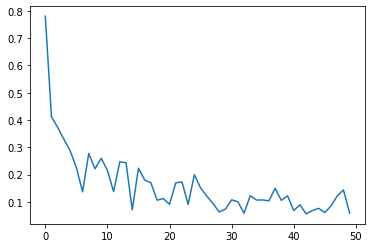

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)
net = FirstCNN()
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr = 0.0001)
fit(50,loss_fn,opt,net)